In [1]:
import xmltodict
from urllib.request import urlopen
import xml.etree.ElementTree as ET
import pandas as pd

from dateutil.parser import parse

import matplotlib.pyplot as plt
from IPython.display import display 

plt.style.use('seaborn-paper')
%matplotlib inline

# Hansard - OralQuestionPeriod

In [15]:
def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    orderOfBusinessList = root.find('HansardBody').iter('OrderOfBusiness')
    
    volume = root.findall(".//ExtractedItem[@Name='Volume']")[0].text
    number = root.findall(".//ExtractedItem[@Name='Number']")[0].text
    session = root.findall(".//ExtractedItem[@Name='Session']")[0].text
    parliament = root.findall(".//ExtractedItem[@Name='Parliament']")[0].text
    speakerName = root.findall(".//ExtractedItem[@Name='SpeakerName']")[0].text
    date = root.findall(".//ExtractedItem[@Name='Date']")[0].text   
#     print(volume)
    
    for orderOfBusiness in orderOfBusinessList:
        
        orderOfBusinessRubric = orderOfBusiness.attrib['Rubric']
#         print('orderOfBusinessRubric', orderOfBusinessRubric)
        if (orderOfBusinessRubric == 'OralQuestionPeriod'):
        
            orderOfBusinessId =  orderOfBusiness.attrib['id']            
            orderOfBusinessCatchLine = orderOfBusiness.find('CatchLine').text
        
            for subjectOfBusiness in orderOfBusiness.findall('SubjectOfBusiness'):

                subjectOfBusinessContent = subjectOfBusiness.find('SubjectOfBusinessContent')
                for intervention in subjectOfBusinessContent.iter('Intervention'):
                    
                    record = {} #Place holder for our record
                    record['orderOfBusinessId'] = orderOfBusinessId
                    record['orderOfBusinessRubric'] = orderOfBusinessRubric
                    record['orderOfBusinessCatchLine'] = orderOfBusinessCatchLine
                    record['volume'] = volume
                    record['number'] = number        
                    record['session'] = session
                    record['parliament'] = parliament
                    record['speakerName'] = speakerName
                    record['date'] = date
                                            
                    try:
                        record['subjectOfBusinessId'] = subjectOfBusiness.attrib['id']
                    except Exception:
                        continue    
                        
                    
                    if subjectOfBusiness.find('SubjectOfBusinessTitle') is not None:
                        record['SubjectOfBusinessTitle'] = subjectOfBusiness.find('SubjectOfBusinessTitle').text.strip()
                    else:
                        record['SubjectOfBusinessTitle'] = 'generic'
                        

                    if subjectOfBusiness.find('FloorLanguage') is not None:
                        record['FloorLanguage'] = subjectOfBusiness.find('FloorLanguage').attrib['language']
                    else:
                        record['FloorLanguage'] = 'EN'

                    record['personSpeaking'] = intervention.findall('PersonSpeaking/Affiliation')[0].text
                    record['personId'] =intervention.findall('PersonSpeaking/Affiliation')[0].attrib['DbId']
                    
                    # Get all texts from intervention - Only one person is speaking per intervention.
#                     content = []
                    
                    content = ET.tostring(intervention.find('Content'), encoding='UTF-8', method='text')
                    record['content'] = content.decode('UTF-8')
#                     for paraText in intervention.iter('ParaText'):
#                         if paraText.text is not None:
#                             content.append(paraText.text)

#                     record['content'] = ' \lineBreak '.join(content)
                    
                    all_records.append(record) #Append this record to all_records. 

    return pd.DataFrame(all_records) #return records as DataFrame



In [25]:
link = 'http://www.ourcommons.ca/Content/House/{parliamentSession}/Debates/{session}/HAN{session}-E.XML'
# link = 'http://www.ourcommons.ca/Content/House/412/Debates/{session}/HAN{session}-E.XML'

link_list = []
session = 10
# session = 236
# session = 264
parliament_session  = {'421' : 265,
                       '412' : 235,
                       '411': 272}

# parliament_session  = {'421' : 10,
#                        '412' : 10,
#                        '411': 210}

for parliament, session  in parliament_session.items():
    print(parliament, session)
    for i in range (1, session + 1):
        temp = link.replace('{parliamentSession}', parliament)
        temp = temp.replace('{session}', '{:03}'.format(i))
        link_list.append(temp)

print('link_list', len(link_list))
print(link_list[1])

421 265
412 235
411 272
link_list 772
http://www.ourcommons.ca/Content/House/421/Debates/002/HAN002-E.XML


In [26]:
from joblib import Parallel, delayed
import multiprocessing
    
df_list = []
def processLink(link):
    print('processing', link)
    urlContent = urlopen(link)
    xml = urlContent.read()
    return xml2df(xml)

num_cores = multiprocessing.cpu_count()
print(num_cores)
    
results = Parallel(n_jobs=num_cores)(delayed(processLink)(i) for i in link_list)



8
processing http://www.ourcommons.ca/Content/House/421/Debates/003/HAN003-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/005/HAN005-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/004/HAN004-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/007/HAN007-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/008/HAN008-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/006/HAN006-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/002/HAN002-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/001/HAN001-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/009/HAN009-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/010/HAN010-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/011/HAN011-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/012/HAN012-E.XML
processing http://www.ourcommons.ca/Content/House/

processing http://www.ourcommons.ca/Content/House/421/Debates/105/HAN105-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/106/HAN106-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/107/HAN107-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/108/HAN108-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/109/HAN109-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/110/HAN110-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/111/HAN111-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/112/HAN112-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/113/HAN113-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/114/HAN114-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/115/HAN115-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/116/HAN116-E.XML
processing http://www.ourcommons.ca/Content/House/42

processing http://www.ourcommons.ca/Content/House/421/Debates/209/HAN209-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/210/HAN210-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/211/HAN211-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/212/HAN212-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/213/HAN213-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/214/HAN214-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/215/HAN215-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/216/HAN216-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/217/HAN217-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/218/HAN218-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/219/HAN219-E.XML
processing http://www.ourcommons.ca/Content/House/421/Debates/220/HAN220-E.XML
processing http://www.ourcommons.ca/Content/House/42

processing http://www.ourcommons.ca/Content/House/412/Debates/048/HAN048-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/049/HAN049-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/050/HAN050-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/051/HAN051-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/052/HAN052-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/053/HAN053-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/054/HAN054-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/055/HAN055-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/056/HAN056-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/057/HAN057-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/058/HAN058-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/059/HAN059-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/412/Debates/152/HAN152-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/153/HAN153-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/154/HAN154-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/155/HAN155-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/156/HAN156-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/157/HAN157-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/158/HAN158-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/159/HAN159-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/160/HAN160-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/161/HAN161-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/162/HAN162-E.XML
processing http://www.ourcommons.ca/Content/House/412/Debates/163/HAN163-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/411/Debates/021/HAN021-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/022/HAN022-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/023/HAN023-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/024/HAN024-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/025/HAN025-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/026/HAN026-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/027/HAN027-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/028/HAN028-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/029/HAN029-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/030/HAN030-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/031/HAN031-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/032/HAN032-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/411/Debates/125/HAN125-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/126/HAN126-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/127/HAN127-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/128/HAN128-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/129/HAN129-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/130/HAN130-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/131/HAN131-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/132/HAN132-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/133/HAN133-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/134/HAN134-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/135/HAN135-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/136/HAN136-E.XML
processing http://www.ourcommons.ca/Content/House/41

processing http://www.ourcommons.ca/Content/House/411/Debates/229/HAN229-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/230/HAN230-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/231/HAN231-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/232/HAN232-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/233/HAN233-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/234/HAN234-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/235/HAN235-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/236/HAN236-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/237/HAN237-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/238/HAN238-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/239/HAN239-E.XML
processing http://www.ourcommons.ca/Content/House/411/Debates/240/HAN240-E.XML
processing http://www.ourcommons.ca/Content/House/41

In [30]:
# results[0]

df_hansard = pd.concat(results)
df_hansard.reset_index(inplace=True)

df_hansard['date'] =  pd.to_datetime(df_hansard['date'])

df_hansard.to_csv('data/hansard_all.csv')
df_hansard.tail()

index FloorLanguage SubjectOfBusinessTitle  \
69663     80            EN             Employment   
69664     81            EN        Points of Order   
69665     82            EN        Points of Order   
69666     83            EN        Points of Order   
69667     84            EN        Points of Order   

                                                 content       date  \
69663  Mr. Speaker, our government has introduced ref... 2013-06-18   
69664  Mr. Speaker, I raised this point of order some... 2013-06-18   
69665  I thank the hon. member for Saanich—Gulf Islan... 2013-06-18   
69666  Mr. Speaker, I heard the comment from the memb... 2013-06-18   
69667  We are certainly not going to get into debate ... 2013-06-18   

           number orderOfBusinessCatchLine orderOfBusinessId  \
69663  NUMBER 272           Oral Questions           8090062   
69664  NUMBER 272           Oral Questions           8090062   
69665  NUMBER 272           Oral Questions           8090062   
69666  NUMBER 272           Oral Questions           8090062   
69667  NUMBER 272           Oral Questions           8090062   

      orderOfBusinessRubric       parliament personId  \
69663    OralQuestionPeriod  41st PARLIAMENT   170869   
69664    OralQuestionPeriod  41st PARLIAMENT   170542   
69665    OralQuestionPeriod  41st PARLIAMENT   170958   
69666    OralQuestionPeriod  41st PARLIAMENT   170302   
69667    OralQuestionPeriod  41st PARLIAMENT   170958   

                                          personSpeaking      session  \
69663  Ms. Kellie Leitch (Parliamentary Secretary to ...  1st SESSION   
69664       Ms. Elizabeth May (Saanich—Gulf Islands, GP)  1st SESSION   
69665                                        The Speaker  1st SESSION   
69666      Mr. Daryl Kramp (Prince Edward—Hastings, CPC)  1st SESSION   
69667                                        The Speaker  1st SESSION   

                                 speakerName subjectOfBusinessId      volume  
69663  Speaker: The Honourable Andrew Scheer             8090323  VOLUME 146  
69664  Speaker: The Honourable Andrew Scheer             8090331  VOLUME 146  
69665  Speaker: The Honourable Andrew Scheer             8090331  VOLUME 146  
69666  Speaker: The Honourable Andrew Scheer             8090331  VOLUME 146  
69667  Speaker: The Honourable Andrew Scheer             8090331  VOLUME 146

In [14]:
df_hansard['content'][0]

b'Mr. Speaker, an astonishing 600 aboriginal women have been murdered or reported missing across Canada. The National Chief of the Assembly of First Nations, Shawn Atleo, has called for a national inquiry. The UN rapporteur has called for a national inquiry.If, in a city the size of Ottawa, 600 women were murdered or missing, there would not have to be protests in the streets to get a national inquiry; one would have been called a very long time ago. Why is the Prime Minister still refusing to hold a national inquiry into the national tragedy of 600 murdered and missing aboriginal women?'

Ethics                                   7074
National Defence                         3745
Taxation                                 3018
The Environment                          2761
Foreign Affairs                          2100
Public Safety                            2043
Employment                               1975
Democratic Reform                        1675
Health                                   1656
Aboriginal Affairs                       1566
Employment Insurance                     1531
International Trade                      1475
Veterans Affairs                         1369
Justice                                  1362
Natural Resources                        1343
Infrastructure                           1330
The Economy                              1297
Citizenship and Immigration              1147
Points of Order                           977
generic                                   907
Indigenous Affairs                        876
Pensions                          

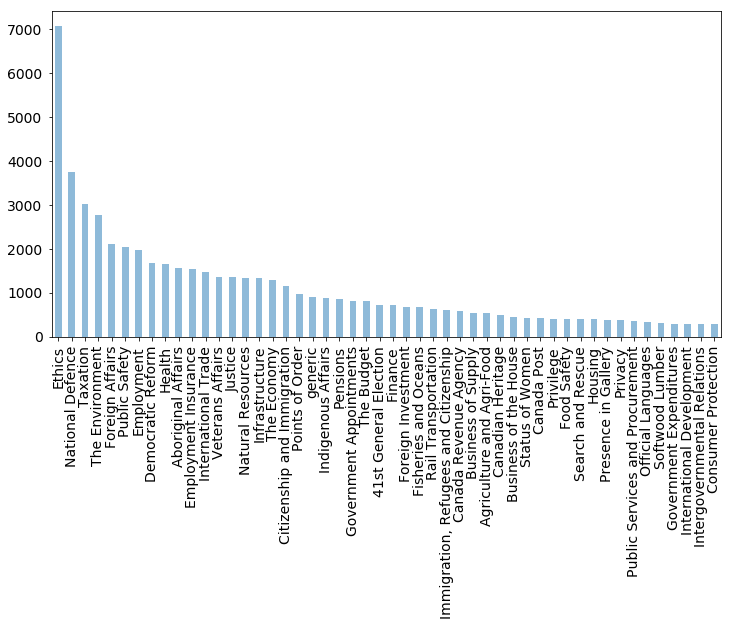

In [33]:
print(df_hansard['SubjectOfBusinessTitle'].value_counts()[:50])

df_hansard['SubjectOfBusinessTitle'].value_counts()[:50].plot(kind='bar', alpha=.5, figsize=(12,6), fontsize=14)

In [ ]:
# https://www.ourcommons.ca/en/open-data#ChamberDebates
link =  'http://www.ourcommons.ca/Content/House/{ParliamentSession}/Debates/{SittingNumber}/HAN{SittingNumber}-E.XML'

# https://www.ourcommons.ca/Content/House/421/Debates/251/HAN251-E.XML
    
link = link.replace('{ParliamentSession}', '421')
link = link.replace('{SittingNumber}', '251')
link = link.replace('{SittingNumber}', '251')

print(link)


def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    orderOfBusinessList = root.find('HansardBody').iter('OrderOfBusiness')
    
    
    for orderOfBusiness in orderOfBusinessList:
        
#         print(orderOfBusiness.find('CatchLine'))
        orderOfBusinessId =  orderOfBusiness.attrib['id']
        orderOfBusinessRubric = orderOfBusiness.attrib['Rubric']
        orderOfBusinessCatchLine = orderOfBusiness.find('CatchLine').text
#         orderOfBusinessFloorLanguage = orderOfBusiness.find('SubjectOfBusiness')
        
#         record['timestamp'] = parse( publicationItem.attrib['Date'])
#         record['speakerId'] = publicationItem.find('Person').attrib['Id']
        paragraphs = []
        for subjectOfBusiness in orderOfBusiness.findall('SubjectOfBusiness'):
            record = {} #Place holder for our record
#             print(subjectOfBusiness.attrib)
            try:
                record['subjectOfBusinessId'] = subjectOfBusiness.attrib['id']
            except Exception:
                continue
                
            record['orderOfBusinessId'] = orderOfBusinessId
            record['orderOfBusinessRubric'] = orderOfBusinessRubric
            record['orderOfBusinessCatchLine'] = orderOfBusinessCatchLine
            
            if subjectOfBusiness.find('SubjectOfBusinessTitle') is not None:
                record['SubjectOfBusinessTitle'] = subjectOfBusiness.find('SubjectOfBusinessTitle').text
            else:
                record['SubjectOfBusinessTitle'] = 'generic'
            
            if subjectOfBusiness.find('FloorLanguage') is not None:
                record['FloorLanguage'] = subjectOfBusiness.find('FloorLanguage').attrib['language']
            else:
                record['FloorLanguage'] = 'EN'
               
#           print(subjectOfBusiness.findall("Intervention/PersonSpeaking/Affiliation"))
            # SpeakerId
#             if subjectOfBusiness.findall("./Intervention/PersonSpeaking/Affiliation") is not None:
#                 record['speakerId'] = subjectOfBusiness.findall("./Intervention/PersonSpeaking/Affiliation")[0].attrib['DbId']
#             else:
#                 record['speakerId'] = '1' # generic
                
                
                
            subjectOfBusinessContent = subjectOfBusiness.find('SubjectOfBusinessContent')
            
#             print(subjectOfBusinessContent.iter('ParaText'))
            content = []
            
            for paraText in subjectOfBusinessContent.iter('ParaText'):
                content.append(paraText.text)
                
            record['content'] = content
            
            all_records.append(record) #Append this record to all_records. 
            
#         record['paragText'] = paragraphs        
#         break
    
    df = pd.DataFrame(all_records)
    df.set_index(df['subjectOfBusinessId'])
    return df #return records as DataFrame

# Id	paragText	speakerId	timestamp

urlContent = urlopen(link)
xml = urlContent.read()
df = xml2df(xml)

# df['content'][2]

df.head()
# df.tail()
# df.info()





In [ ]:
# for row in df['content'].values:
#     print(row)

# df

In [ ]:

link = 'http://www.ourcommons.ca/Parliamentarians/en/PublicationSearch?View=D&Item=&ParlSes=42-1&oob=&Topic=&Per=&Prov=&Cauc=&Text=&RPP=15&order=&targetLang=&SBS=0&MRR=150000&PubType=37&xml=1'
#        'http://www.ourcommons.ca/Parliamentarians/en/PublicationSearch?View=L&Item=&ParlSes=42-1&Topic=38047&com=&Per=&Prov=&Cauc=&PartType=&Text=&RPP=15&order=&targetLang=&SBS=0&MRR=2000000&PubType=40017&xml=1'
urlContent = urlopen(link)
xml = urlContent.read()
print(xml)

In [ ]:
# print(len(doc['Results']))

# print(doc['Results']['Publications']['Publication'][0]['PublicationItems']['PublicationItem'][0]
#       ['XmlContent']['Intervention']['Content']['ParaText'][1])



# <PublicationItem Id="9326459" EventId="9885804" 
# VideoURL="" Sequence="5" Page="16240" PdfPage="4" 
# TypeId="38" Date="2017-12-11" Hour="11" Minute="12" Second="20" 
# FacebookLink="?PubType=37&Item=9326459" TwitterLink="">
from datetime import datetime




def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    for publicationItem in root.iter('PublicationItem'):
        record = {} #Place holder for our record
        record['Id'] =  publicationItem.attrib['Id']
        record['timestamp'] = parse( publicationItem.attrib['Date'])
        record['speakerId'] = publicationItem.find('Person').attrib['Id']
        paragraphs = []
        for paratext in publicationItem.find('XmlContent').iter('ParaText'):
            paragraphs.append(paratext.text)
            
        record['paragText'] = paragraphs

        
    
        all_records.append(record) #Append this record to all_records. 
#         break
    
    df = pd.DataFrame(all_records)
    df.set_index(df['Id'])
    return df #return records as DataFrame

# print(urlContent.read())
df = xml2df(xml)

df.to_csv('results.csv' , sep='\t', encoding='utf-8')

# df
# df.describe()


# for item in doc['Results']['Publications']['Publication'][0]
# ['PublicationItems']['PublicationItem']:
# #     print(item['XmlContent']['Intervention']['Content']['ParaText'])
# #     for key in item.keys():
# #         print(key, item[key])
        

#     break
    
    
